In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pickle
import os

In [ ]:
#audio = tfio.audio.AudioIOTensor('../DoReMir/initslurtest_vn/initslurtest_vn_wav/slurtest01.wav')
sr = 44100

In [ ]:
# Conversion to tensor
audio_tensor = tf.squeeze(audio[:], axis=[-1])
audio_tensor = tf.cast(audio_tensor, tf.float32)/np.max(audio_tensor)

In [ ]:
# Automatic trimming
position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.1)
print(position)

START = position[0]
END = position[1]
print(START, END)

processed = audio_tensor[START:END]

fig, axs = plt.subplots(2,1, figsize=(20,2))
[ax.plot(tensor.numpy()) for ax, tensor in zip(axs, [audio_tensor, processed])]

In [ ]:
def multi_window_spectrogram(audio_tensor, win_sizes, hop_size, mels, fmin, fmax, sr=44100):
    spects = []
    for win_size in win_sizes:
        spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=win_size, window=win_size, stride=hop_size)
        # Should NFFT be same as window size always?
        mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sr, mels=mels, fmin=fmin, fmax=fmax)
        dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
        spects.append(dbscale_mel_spectrogram)
    return spects

In [ ]:
HOP = 440
MELS = 80
START = 0
END = len(audio_tensor)

In [ ]:
spects = multi_window_spectrogram(audio_tensor, [1024, 2048, 4096], HOP, MELS, 27.5, 16000.0)

In [ ]:
# Load from file
with open('../DoReMir/initslurtest_vn/spectrogram/slurtest07.pickle', 'rb') as handle:
    spects=pickle.load(handle)
print(np.array(spects).shape)

In [ ]:
stds = [np.std(spect, 1) for spect in spects]
means = [np.mean(spect, 1) for spect in spects]

spects = [(spect - mean)/std for (spect, mean, std) in zip(spects, means, stds)]

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 5))
axs[0].imshow(spects[0])
axs[1].imshow(spects[1])
axs[2].imshow(spects[2])


In [3]:
def get_label_vector(times, onset_times, fuzzy=False):
    a = np.reshape(onset_times, (-1,1))
    b = np.reshape(times, (1,-1))
    onset_onehot = np.sum(np.abs(a - b) < HOP/(2*sr), 0)
    onset_wide = np.sum(np.abs(a - b) < 3*HOP/(2*sr), 0)
    onset_fuzzy = 0.25*onset_wide + 0.25*onset_onehot
    print("Sum of onehot: ", np.sum(onset_onehot))
    print("Len of onset times: ", len(onset_times))
    #fig, axs = plt.subplots(3, 1, figsize=(20,1))
    #axs[0].imshow(np.reshape(onset_onehot[:200], (1,200)))
    #axs[1].imshow(np.reshape(onset_wide[:200], (1,200)))
    #axs[2].imshow(np.reshape(onset_fuzzy[:200], (1,200)))
    
    if fuzzy: 
        return onset_fuzzy
    else:
        return onset_onehot
    



In [4]:
frame_dir = 'datasets/initslurtest_vn/frames/'
label_dir = 'datasets/initslurtest_vn/initslurtest_vn_annotations/'
audio_dir = 'datasets/initslurtest_vn/initslurtest_vn_wav/'
HOP = 440
sr = 44100
switch = False
N_MARGIN = 7
clips_spects = []
clips_onsets = []
for n in range(1,20):
    if n==17:
        continue
        # TODO: solve the 17 case
    print(n)
    frame_name = frame_dir + "slurtest{:02d}".format(n) + ".pickle"
    label_name = label_dir+"{:02d}".format(n)+".txt"
    audio_name  = audio_dir + "slurtest{:02d}".format(n) + ".wav"
    
    # Get audio
    audio = tfio.audio.AudioIOTensor(audio_name)
    length = len(audio)/sr
    
    # Get label vector
    with open(frame_name, 'rb') as handle:
        new_spect = np.array(pickle.load(handle))
        print(new_spect.shape)
    times = np.arange(0, length, HOP/sr)
    print("Audio clip defined from {:.3f} s to {:.3f} s".format(0, length))
    print("With a feature frequency of {:.3f} s this yields {} features".format(HOP/sr, len(times)))
    onset_times = genfromtxt(label_name, delimiter=',')
    print("Onsets start at {} and end at {}".format(onset_times[0], onset_times[-1]))
    labels = get_label_vector(times, onset_times, fuzzy=True)[N_MARGIN:-N_MARGIN-1]
    print(labels.shape)
    print()
    clips_spects.append(new_spect)
    clips_onsets.append(labels)

1
(1686, 80, 15, 3)
Audio clip defined from 0.000 s to 16.962 s
With a feature frequency of 0.010 s this yields 1701 features
Onsets start at 0.767 and end at 15.158
Sum of onehot:  62
Len of onset times:  62
(1686,)

2
(1609, 80, 15, 3)
Audio clip defined from 0.000 s to 16.196 s
With a feature frequency of 0.010 s this yields 1624 features
Onsets start at 0.598 and end at 14.528
Sum of onehot:  61
Len of onset times:  61
(1609,)

3
(1646, 80, 15, 3)
Audio clip defined from 0.000 s to 16.567 s
With a feature frequency of 0.010 s this yields 1661 features
Onsets start at 0.838 and end at 14.697
Sum of onehot:  61
Len of onset times:  61
(1646,)

4
(1585, 80, 15, 3)
Audio clip defined from 0.000 s to 15.961 s
With a feature frequency of 0.010 s this yields 1600 features
Onsets start at 0.458 and end at 14.867
Sum of onehot:  75
Len of onset times:  75
(1585,)

5
(3403, 80, 15, 3)
Audio clip defined from 0.000 s to 34.099 s
With a feature frequency of 0.010 s this yields 3418 features
On

TypeError: only integer scalar arrays can be converted to a scalar index

In [80]:
n_train = 9
n_val = 9
n_test = 0
n_tot = n_train + n_val + n_test

# Sample test/val/train split indices
from numpy.random import default_rng
rng = default_rng(119)
split_idx = rng.choice(np.arange(n_tot), size=n_tot, replace=False)

X_train = np.concatenate([clips_spects[i] for i in split_idx[:n_train]])
y_train = np.concatenate([clips_onsets[i] for i in split_idx[:n_train]])

X_val = np.concatenate([clips_spects[i] for i in split_idx[n_train:n_train+n_val]])
y_val = np.concatenate([clips_onsets[i] for i in split_idx[n_train:n_train+n_val]])

X_test = np.concatenate([clips_spects[i] for i in split_idx[-n_test:]])
y_test = np.concatenate([clips_onsets[i] for i in split_idx[-n_test:]])


In [81]:
# Normalize
resh_train = np.reshape(X_train, (len(X_train)*15,80,3))
mean_train = resh_train.mean(0).reshape((1,80,1,3))
std_train = resh_train.std(0).reshape((1,80,1,3))

X_train = (X_train - mean_train)/std_train
X_val = (X_val - mean_train)/std_train
X_test = (X_test - mean_train)/std_train

In [82]:
train_samples, y_dim, x_dim, n_channels = X_train.shape

sets = ["Train", "Val", "Test"]
y_vecs = [y_train, y_val, y_test]
X_vecs = [X_train, X_val, X_test]
print("Set \t Frames  \t Onset ratio")
print("--------------------------")
[print("{} \t {} \t {} \t {:.3f}".format(
    set_name,
    len(X_vec),
    len(y_vec),
    np.sum(y_vec)/len(y_vec)
)) for (set_name, X_vec, y_vec) in zip(sets, X_vecs, y_vecs)]

Set 	 Frames  	 Onset ratio
--------------------------
Train 	 28345 	 28345 	 0.031
Val 	 33628 	 33628 	 0.030
Test 	 61973 	 61973 	 0.031


[None, None, None]

In [99]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(y_dim, x_dim, n_channels)),
    tf.keras.layers.Reshape((x_dim, y_dim, n_channels)),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 10,
        kernel_size = (7,3),
        strides = 1
    ),
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 20,
        kernel_size = (3,3),
        strides = 1
    ),  
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(128, activation = 'sigmoid'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [101]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(y_dim, x_dim, n_channels)),
    tf.keras.layers.Reshape((x_dim, y_dim, n_channels)),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 1,
        kernel_size = (7,3),
        strides = 1
    ),
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Conv2D(
        activation = 'relu',
        filters = 1,
        kernel_size = (3,3),
        strides = 1
    ),  
    tf.keras.layers.MaxPooling2D(
         pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(64, activation = 'sigmoid'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [71]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(y_dim, x_dim, n_channels)),
    tf.keras.layers.Reshape((x_dim, y_dim, n_channels)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [102]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 15, 80, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 9, 78, 1)          64        
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 9, 26, 1)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 24, 1)          10        
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 8, 1)          0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 56)              

In [103]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [86]:
model.evaluate(x=X_val, y=y_val)

1051/1051 [==============================] - 11s 9ms/step - loss: 1.3750 - accuracy: 0.0000e+00


[1.3750406503677368, 0.0]

In [104]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs = 10,
    batch_size = 128
)

Epoch 1/10
222/222 [==============================] - 14s 55ms/step - loss: 0.1566 - accuracy: 0.9062 - val_loss: 0.1320 - val_accuracy: 0.9086
Epoch 2/10
222/222 [==============================] - 12s 54ms/step - loss: 0.1401 - accuracy: 0.9075 - val_loss: 0.1298 - val_accuracy: 0.9086
Epoch 3/10
222/222 [==============================] - 12s 55ms/step - loss: 0.1374 - accuracy: 0.9075 - val_loss: 0.1288 - val_accuracy: 0.9086
Epoch 4/10
222/222 [==============================] - 12s 54ms/step - loss: 0.1348 - accuracy: 0.9075 - val_loss: 0.1279 - val_accuracy: 0.9086
Epoch 5/10
222/222 [==============================] - 14s 63ms/step - loss: 0.1335 - accuracy: 0.9075 - val_loss: 0.1268 - val_accuracy: 0.9086
Epoch 6/10
222/222 [==============================] - 17s 78ms/step - loss: 0.1320 - accuracy: 0.9075 - val_loss: 0.1262 - val_accuracy: 0.9086
Epoch 7/10
222/222 [==============================] - 14s 61ms/step - loss: 0.1303 - accuracy: 0.9075 - val_loss: 0.1235 - val_accuracy:

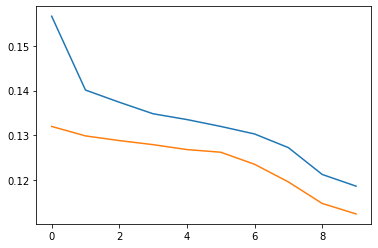

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [37]:
model.evaluate(x=X_test, y=y_test)

96/96 [==============================] - 1s 8ms/step - loss: 0.1705 - accuracy: 0.8957


[0.1705045998096466, 0.8956975340843201]

## Audio analysis

In [138]:
audio = tfio.audio.AudioIOTensor('../DoReMir/initslurtest_vn/initslurtest_vn_wav/slurtest04.wav')
audio_tensor = tf.squeeze(audio[:], axis=[-1])
audio_tensor = tf.cast(audio_tensor, tf.float32)/np.max(audio_tensor)

In [139]:
with open('../DoReMir/initslurtest_vn/spectrogram/slurtest04.pickle', 'rb') as handle:
    spects=pickle.load(handle)


In [140]:
onset_times = genfromtxt('../DoReMir/initslurtest_vn/initslurtest_vn_annotations/04.txt', delimiter=',')
times = np.arange(0, len(audio_tensor)/44100, 440/44100)
labels = get_label_vector(times, onset_times, fuzzy=False)

Sum of onehot:  75
Len of onset times:  75


In [141]:
with open('../DoReMir/initslurtest_vn/frames/slurtest04.pickle', 'rb') as handle:
    frames=pickle.load(handle)
print(frames.shape)

(1585, 80, 15, 3)


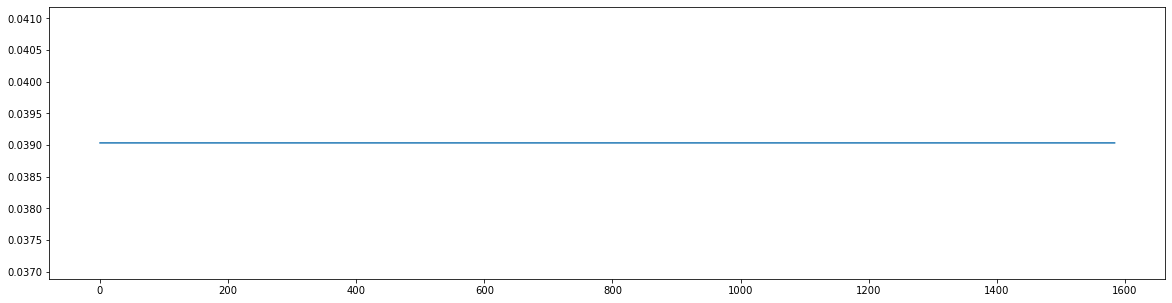

[[0.03903475]
 [0.03903475]
 [0.03903475]
 ...
 [0.03903475]
 [0.03903475]
 [0.03903475]]


ValueError: object too deep for desired array

In [144]:
from scipy.signal import find_peaks
from librosa.util import peak_pick

pred_onsets = model.predict(frames)
plt.figure(figsize=(20,5))
plt.plot(pred_onsets)
plt.show()
print(pred_onsets)

kernel_size = 5
smoothed = np.convolve(pred_onsets, np.hamming(kernel_size), mode='same')
plt.figure(figsize=(20,5))
plt.plot(smoothed)

peaks, _ = find_peaks(smoothed, height=0.005)
print(len(peaks))
for index in range(len(peaks)): 
    
    plt.scatter(x=peaks[index], y=smoothed[peaks[index]], c="red")

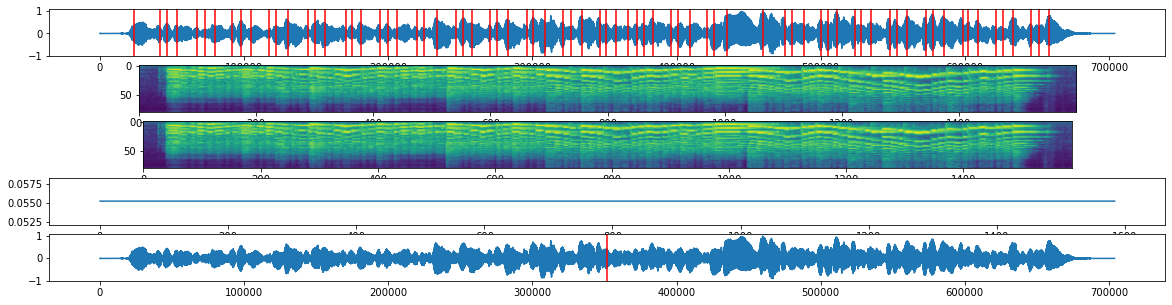

In [134]:
fig, axs = plt.subplots(5, 1, figsize=(20,5))
axs[0].plot(audio_tensor.numpy())
for index in range(len(labels)):
    if labels[index]>0.5:    
        axs[0].axvline(x=HOP*(index+7), c="red")
axs[0].set_autoscale_on(False)

axs[1].imshow(spects[0])
axs[1].set_autoscale_on(False)

axs[2].imshow(np.transpose(frames[:,:,8,0]))
axs[2].set_autoscale_on(False)

axs[3].plot(pred_onsets[pred_onsets>-50])
axs[4].plot(audio_tensor.numpy())
for index in range(len(peaks)):    
    axs[4].axvline(x=HOP*(peaks[index]+7), c="red")

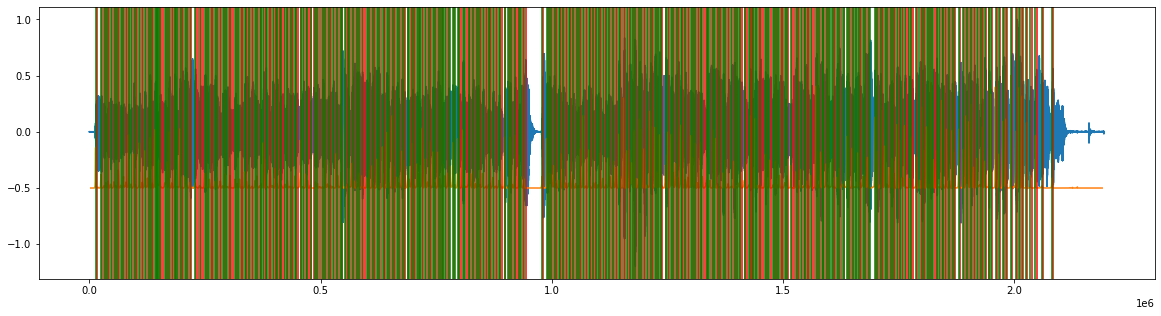

In [113]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(audio_tensor)), audio_tensor.numpy())
a = np.max(pred_onsets)
b = np.min(pred_onsets)
pred_onsets_scaled = (pred_onsets-((a+b)/2))/(a-b)
plt.plot(np.arange(7*440,len(audio_tensor)-8*440, 440), pred_onsets_scaled)
for index in range(len(labels)):
    if labels[index]>0.5:    
        plt.axvline(x=HOP*(index+7), c="red")
        
for index in range(len(peaks)): 
    plt.axvline(x=HOP*(peaks[index]+7), c="green")

In [114]:
f = open("../DoReMir/initslurtest_vn/model-output/bockmodel0005-slurtest07.txt", "w")
for i in range(len(peaks)):
    f.write(str(np.round((peaks[i]+7)*440/44100, decimals=2))+ "\n")
f.close()

In [122]:
filters, biases = model.layers[-1].get_weights()
print(filters, biases)

[[ 0.15269421]
 [-0.2703586 ]
 [ 0.03700621]
 [ 0.16353598]
 [ 0.20317614]
 [-0.12514779]
 [-0.09647097]
 [-0.12968095]
 [-0.19269772]
 [ 0.19641231]
 [ 0.06363827]
 [-0.22487688]
 [ 0.17272538]
 [ 0.19531436]
 [-0.15371719]
 [-0.14074457]
 [ 0.02874292]
 [ 0.02926812]
 [ 0.05389025]
 [ 0.19083121]
 [ 0.02943327]
 [-0.08018146]
 [-0.15551586]
 [-0.07212115]
 [-0.13438341]
 [-0.09619058]
 [ 0.21494037]
 [-0.22954233]
 [-0.21317653]
 [-0.22935757]
 [-0.19273667]
 [-0.23823476]
 [-0.07713889]
 [-0.19274192]
 [-0.00069036]
 [ 0.01796682]
 [-0.06884082]
 [-0.2132525 ]
 [ 0.10348446]
 [-0.01228169]
 [ 0.12221756]
 [ 0.11706427]
 [ 0.14465903]
 [-0.19506   ]
 [ 0.11105461]
 [-0.15919028]
 [-0.07752404]
 [-0.21670957]
 [ 0.04058944]
 [ 0.1522638 ]
 [-0.19094254]
 [ 0.20756978]
 [-0.12590554]
 [ 0.02434419]
 [ 0.05077763]
 [-0.20989469]
 [ 0.16192682]
 [-0.21964517]
 [-0.07661561]
 [ 0.09286875]
 [-0.15479049]
 [ 0.02299358]
 [ 0.16837807]
 [-0.2505039 ]
 [ 0.07226129]
 [ 0.1343925 ]
 [-0.19202